In [1]:
import os
import numpy as np
import pandas as pd

In [103]:
# load data into pandas df
file_path = "D:/Scripts/bridges_project/data/climate_bridges.csv"

climate_bridges = pd.read_csv(file_path, header= 0)

In [105]:
climate_bridges.count()

Year                         178722
1 - State Code               178722
8 - Structure Number         178722
Average Relative Humidity    178722
Average Temperature          178722
                              ...  
UNDWATER_FLAG_092BF          178722
SPEC_FLAG_092AF              178722
INSPECT_FLAG_090F            178722
REL_BRIDGE_AGE               178722
STRUCTURE_NUMBER_008_ID      178722
Length: 61, dtype: int64

In [3]:
# create target col --> see databricks page
def getAge(row):
    val_list = []
    deckVal = row['DECK_COND_058']
    if deckVal != -1:
        val_list.append(deckVal)
    supVal = row['SUPERSTRUCTURE_COND_059']
    if supVal != -1:
        val_list.append(supVal)
    subVal = row['SUBSTRUCTURE_COND_060']
    if subVal != -1:
        val_list.append(subVal)
    chanVal = row['CHANNEL_COND_061']
    if chanVal != -1:
        val_list.append(chanVal)
    culVal = row['CULVERT_COND_062']
    if culVal != -1:
        val_list.append(culVal)
    
    count = len(val_list)
    tot = sum(val_list)
    if count != 0:
        if 0 in val_list:
            avgVal = 0
        else:
            avgVal = tot/count
    else:
        avgVal = 0
        
    return avgVal
    
climate_bridges['avg_COND'] = climate_bridges.apply(getAge, axis= 1)

In [4]:
# filter down to concrete and steel bridges
concreteSteel = climate_bridges[(climate_bridges['STRUCTURE_KIND_043A'] != 7) | (climate_bridges['STRUCTURE_KIND_043A'] != 8) |
                                (climate_bridges['STRUCTURE_KIND_043A'] != 9) | (climate_bridges['STRUCTURE_KIND_043A'] != 0)]

In [100]:
concreteSteel.count()

1 - State Code                                  178722
Average Relative Humidity                       178722
Average Temperature                             178722
Maximum Temperature                             178722
Mean Wind Speed                                 178722
Minimum Temperature                             178722
Number of Freeze-Thaw Cycles                    178722
Number of Snowfall Days                         178722
Number of Days with Measurable Precipitation    178722
Number of Days with Temperature Below 0?C       178722
Prevailing Wind Direction                       178722
Time of Wetness                                 178722
Total Precipitation                             178722
SERVICE_LEVEL_005C                              178722
DIRECTION_005E                                  178722
FUNCTIONAL_CLASS_026                            178722
YEAR_BUILT_027                                  178722
TRAFFIC_LANES_ON_028A                           178722
TRAFFIC_LA

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

### ML Prep ONLY FOR NON-CLIMATE MODELS

Will need to repeat steps for Climate Models before ML tasks.

In [6]:
nonClimateFeatures = ['Year', '1 - State Code', 'SERVICE_LEVEL_005C', 'DIRECTION_005E', 'FUNCTIONAL_CLASS_026',
       'YEAR_BUILT_027', 'TRAFFIC_LANES_ON_028A', 'TRAFFIC_LANES_UND_028B',
       'ADT_029', 'MEDIAN_CODE_033', 'DEGREES_SKEW_034',
       'STRUCTURE_FLARED_035', 'OPEN_CLOSED_POSTED_041', 'SERVICE_ON_042A',
       'SERVICE_UND_042B', 'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B',
       'APPR_KIND_044A', 'APPR_TYPE_044B', 'MAIN_UNIT_SPANS_045',
       'APPR_SPANS_046', 'MAX_SPAN_LEN_MT_048', 'STRUCTURE_LEN_MT_049',
       'OPERATING_RATING_064', 'DECK_GEOMETRY_EVAL_068', 'WATERWAY_EVAL_071', 'APPR_ROAD_EVAL_072',
       'INSPECT_FREQ_MONTHS_091', 'YEAR_RECONSTRUCTED_106',
       'DECK_STRUCTURE_TYPE_107', 'SURFACE_TYPE_108A', 'MEMBRANE_TYPE_108B',
       'DECK_PROTECTION_108C', 'PERCENT_ADT_TRUCK_109', 'SCOUR_CRITICAL_113',
       'SUFFICIENCY_RATING', 'YEAR', 'FRACTURE_FLAG_092AF',
       'UNDWATER_FLAG_092BF', 'SPEC_FLAG_092AF', 'INSPECT_FLAG_090F',
       'REL_BRIDGE_AGE', 'avg_COND']

In [7]:
corrFeatCheck = concreteSteel[nonClimateFeatures]

In [ ]:
# create correlation matrix
corr_db = corrFeatCheck.corr(numeric_only= True)
fig = plt.figure(figsize= (14, 14))
sns.heatmap(corr_db.round(1), annot= True)
plt.show;

In [ ]:
upper_corr_mat = corr_db.where(np.triu(np.ones(corr_db.shape), k= 1).astype(bool))
unique_corr_pairs = upper_corr_mat.unstack().dropna()
sorted_mat = unique_corr_pairs.sort_values()

In [ ]:
for pair, value in sorted_mat.items():
    if np.abs(value) >= 0.5:
        print(pair, value)

### Features to Remove based off of Correlation Check, using cutoff of 0.65:
- REL_BRIDGE_AGE
- DECK_GEOMETRY_EVAL_068
- MEMBRANE_TYPE_108B
- Year

In [8]:
corrFeatCheck = corrFeatCheck.drop(columns= ['Year', 'REL_BRIDGE_AGE', 'DECK_GEOMETRY_EVAL_068', 'MEMBRANE_TYPE_108B'])

In [ ]:
corrFeatCheck.columns.tolist

In [9]:
## convert cols to cat dtype for certain cols
cat_cols = ['1 - State Code', 'SERVICE_LEVEL_005C', 'DIRECTION_005E', 'MEDIAN_CODE_033', 'SERVICE_ON_042A', 'SERVICE_UND_042B',
           'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'APPR_KIND_044A', 'APPR_TYPE_044B', 'DECK_STRUCTURE_TYPE_107',
           'SURFACE_TYPE_108A', 'DECK_PROTECTION_108C']
corrFeatCheck[cat_cols] = corrFeatCheck[cat_cols].astype('category')

In [ ]:
corrFeatCheck.info()

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from xgboost.sklearn import XGBRegressor
import statsmodels.api as sm

In [ ]:
pip install xgboost

In [11]:
# scale numerical columns
numerical = corrFeatCheck.select_dtypes(include= 'float64').columns
corrFeatCheck.loc[:, numerical] = StandardScaler().fit_transform(corrFeatCheck.loc[:, numerical])

In [19]:
y_len = len(y_test)
X_shape = X_test.shape[1]
# helper function to get adj R2 score
def get_adj_r2(score):
    adj_r2 = 1 - (1 - score) * (y_len - 1) / (y_len - X_shape - 1)
    return adj_r2

## Models w/out Climate Data, w/Sufficiency Rating

In [23]:
featureNames = (corrFeatCheck.drop(columns= ['avg_COND'])).columns.tolist()

In [12]:
# set up train and test data
X_train, X_test, y_train, y_test = train_test_split(corrFeatCheck.drop(columns= ['avg_COND']),
                                                    corrFeatCheck['avg_COND'],
                                                    test_size= 0.2,
                                                    random_state= 42)

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
lr_score = lr.score(X_test, y_test)
lr_score

0.476477475058811

In [21]:
lr_adj_r2 = get_adj_r2(lr_score)
lr_adj_r2

0.4826411795062744

In [24]:
lr_coef = lr.coef_.tolist()
for i in range(len(featureNames)):
    print(lr_coef[i], featureNames[i])

-0.001832967885355016 1 - State Code
0.00445378575239469 SERVICE_LEVEL_005C
-0.05923036255825254 DIRECTION_005E
-0.052366809131631185 FUNCTIONAL_CLASS_026
0.4443979249459385 YEAR_BUILT_027
-1.4710455076283324e-15 TRAFFIC_LANES_ON_028A
-9.71445146547012e-16 TRAFFIC_LANES_UND_028B
0.006195625877184008 ADT_029
-0.07574872622168041 MEDIAN_CODE_033
-0.05370007390028169 DEGREES_SKEW_034
0.0006394143610836176 STRUCTURE_FLARED_035
-0.009577177436880902 OPEN_CLOSED_POSTED_041
0.0027115489960584547 SERVICE_ON_042A
-0.019971064848147983 SERVICE_UND_042B
-0.006237109989247691 STRUCTURE_KIND_043A
-0.0058407618626890164 STRUCTURE_TYPE_043B
-0.011402043725658924 APPR_KIND_044A
-0.011292504467042977 APPR_TYPE_044B
0.02199571656131269 MAIN_UNIT_SPANS_045
0.02140782630303257 APPR_SPANS_046
0.09295488461218093 MAX_SPAN_LEN_MT_048
-0.044950189501052264 STRUCTURE_LEN_MT_049
-0.07440675943584422 OPERATING_RATING_064
0.06420479310190604 WATERWAY_EVAL_071
0.02736705027993651 APPR_ROAD_EVAL_072
0.0718203964855

In [25]:
dt = DecisionTreeRegressor(random_state= 42)

In [27]:
cv_dt = cross_val_score(estimator= dt, X= X_train, y= y_train, scoring= 'r2')
cv_dt

array([0.54781233, 0.54981765, 0.55882532, 0.5595235 , 0.55704746])

In [28]:
avg_r2 = np.mean(cv_dt)
avg_r2

0.5546052512196843

In [32]:
values = get_adj_r2(cv_dt)
dt_adj_r2 = values.mean()
dt_adj_r2

0.5541312412366659

In [33]:
enet = ElasticNet(random_state= 0)
enet.fit(X_train, y_train)

ElasticNet(random_state=0)

In [34]:
enet_score = enet.score(X_test, y_test)
enet_score

0.0763230554854385

In [35]:
enet_adj_r2 = get_adj_r2(enet_score)
enet_adj_r2

0.0753400351557586

In [ ]:
enet.get_params()

In [36]:
enet_coef = enet.coef_.tolist()
for i in range(len(featureNames)):
    print(enet_coef[i], featureNames[i])

-0.0003292749357323166 1 - State Code
0.0 SERVICE_LEVEL_005C
0.0 DIRECTION_005E
-0.0 FUNCTIONAL_CLASS_026
0.03641859816350686 YEAR_BUILT_027
0.0 TRAFFIC_LANES_ON_028A
0.0 TRAFFIC_LANES_UND_028B
-0.0 ADT_029
0.0 MEDIAN_CODE_033
-0.0 DEGREES_SKEW_034
0.0 STRUCTURE_FLARED_035
-0.0 OPEN_CLOSED_POSTED_041
-0.0 SERVICE_ON_042A
0.0 SERVICE_UND_042B
0.0 STRUCTURE_KIND_043A
0.0 STRUCTURE_TYPE_043B
0.0 APPR_KIND_044A
-0.0 APPR_TYPE_044B
0.0 MAIN_UNIT_SPANS_045
-0.0 APPR_SPANS_046
0.0 MAX_SPAN_LEN_MT_048
0.0 STRUCTURE_LEN_MT_049
0.0 OPERATING_RATING_064
0.0 WATERWAY_EVAL_071
0.0 APPR_ROAD_EVAL_072
0.0 INSPECT_FREQ_MONTHS_091
-0.0 YEAR_RECONSTRUCTED_106
-0.0 DECK_STRUCTURE_TYPE_107
-0.0 SURFACE_TYPE_108A
0.0 DECK_PROTECTION_108C
0.0 PERCENT_ADT_TRUCK_109
0.0 SCOUR_CRITICAL_113
0.034089021876743654 SUFFICIENCY_RATING
0.0 YEAR
-0.0 FRACTURE_FLAG_092AF
-0.0 UNDWATER_FLAG_092BF
-0.0 SPEC_FLAG_092AF
-0.0 INSPECT_FLAG_090F


In [ ]:
# rr = Ridge(random_state= 42)
# rr.fit(X_train, y_train)

In [ ]:
# rr_pred = rr.predict(X_test)
# rr_rmse = np.sqrt(mean_squared_error(y_test, rr_pred))
# rr_rmse

In [ ]:
# rr_coef = rr.coef_.tolist()
# for i in range(len(featureNames)):
#     print(rr_coef[i], featureNames[i])

In [95]:
xgb1 = XGBRegressor(n_estimators= 1000, max_depth= 10, random_state= 42, enable_categorical= True)
xgb1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [97]:
xgb1_score = xgb1.score(X_test, y_test)
xgb1_score

0.809571481312133

In [98]:
xgb1_adj_r2 = get_adj_r2(xgb1_score)
xgb1_adj_r2

0.8093688183504419

## Model w/out Climate Data, w/out Sufficiency Rating

In [42]:
featureNames2 = (corrFeatCheck.drop(columns= ['avg_COND', 'SUFFICIENCY_RATING'])).columns.tolist()

In [37]:
# set up train and test data
X_train2, X_test2, y_train2, y_test2 = train_test_split(corrFeatCheck.drop(columns= ['avg_COND', 'SUFFICIENCY_RATING']),
                                                    corrFeatCheck['avg_COND'],
                                                    test_size= 0.2,
                                                    random_state= 42)

In [38]:
lr2 = LinearRegression()
lr2.fit(X_train2, y_train2)

LinearRegression()

In [40]:
lr2_score = lr2.score(X_test2, y_test2)
lr2_score

0.4183355427725326

In [41]:
lr2_adj_r2 = get_adj_r2(lr2_score)
lr2_adj_r2

0.41771650817401573

In [43]:
lr2_coef = lr2.coef_.tolist()
for i in range(len(featureNames2)):
    print(lr2_coef[i], featureNames2[i])

-0.0022633726556380612 1 - State Code
0.006881723934889391 SERVICE_LEVEL_005C
-0.047103324800209234 DIRECTION_005E
-0.0635896776960835 FUNCTIONAL_CLASS_026
0.5682174749218438 YEAR_BUILT_027
0.0 TRAFFIC_LANES_ON_028A
-2.7311052724909857e-16 TRAFFIC_LANES_UND_028B
-0.008727689118646617 ADT_029
-0.027763460782078926 MEDIAN_CODE_033
-0.0565402561527955 DEGREES_SKEW_034
-0.0002386353920744783 STRUCTURE_FLARED_035
-0.0755840747523355 OPEN_CLOSED_POSTED_041
-0.0013951658548790964 SERVICE_ON_042A
-0.024773857132558343 SERVICE_UND_042B
0.003165779570242155 STRUCTURE_KIND_043A
0.00024150611419875072 STRUCTURE_TYPE_043B
-0.006734255064532018 APPR_KIND_044A
-0.015424397369445718 APPR_TYPE_044B
0.01391317480334446 MAIN_UNIT_SPANS_045
0.0001464007509521959 APPR_SPANS_046
0.07547145195831322 MAX_SPAN_LEN_MT_048
-0.03151177266625056 STRUCTURE_LEN_MT_049
0.023410994000155026 OPERATING_RATING_064
0.07150865686801544 WATERWAY_EVAL_071
0.0655798868869983 APPR_ROAD_EVAL_072
0.09950037299563717 INSPECT_FREQ

In [44]:
dt2 = DecisionTreeRegressor(random_state= 42)

In [45]:
cv_dt2 = cross_val_score(estimator= dt2, X= X_train2, y= y_train2, scoring= 'r2')
cv_dt2

array([0.49391804, 0.49113214, 0.49267016, 0.49367631, 0.52054786])

In [46]:
np.mean(cv_dt2)

0.4983889030204761

In [47]:
values2 = get_adj_r2(cv_dt2)
dt2_adj_r2 = values2.mean()
dt2_adj_r2

0.4978550649628605

In [48]:
enet2 = ElasticNet(random_state= 0)
enet2.fit(X_train2, y_train2)

ElasticNet(random_state=0)

In [49]:
enet2_score = enet2.score(X_test2, y_test2)
enet2_score

0.052395122047018794

In [50]:
enet2_adj_r2 = get_adj_r2(enet2_score)
enet2_adj_r2

0.051386636488227166

In [ ]:
enet2_preds = enet2.predict(X_test2)

In [ ]:
enet2_rmse = np.sqrt(mean_squared_error(y_test2, enet2_preds))
enet2_rmse

In [ ]:
enet2.get_params()

In [51]:
enet2_coef = enet2.coef_.tolist()
for i in range(len(featureNames2)):
    print(enet2_coef[i], featureNames2[i])

-0.00037414803531742654 1 - State Code
0.0 SERVICE_LEVEL_005C
0.0 DIRECTION_005E
-0.0 FUNCTIONAL_CLASS_026
0.047506670712218944 YEAR_BUILT_027
0.0 TRAFFIC_LANES_ON_028A
0.0 TRAFFIC_LANES_UND_028B
0.0 ADT_029
0.0 MEDIAN_CODE_033
-0.0 DEGREES_SKEW_034
0.0 STRUCTURE_FLARED_035
-0.0 OPEN_CLOSED_POSTED_041
-0.0 SERVICE_ON_042A
0.0 SERVICE_UND_042B
0.0 STRUCTURE_KIND_043A
0.0 STRUCTURE_TYPE_043B
0.0 APPR_KIND_044A
-0.0 APPR_TYPE_044B
0.0 MAIN_UNIT_SPANS_045
-0.0 APPR_SPANS_046
0.0 MAX_SPAN_LEN_MT_048
0.0 STRUCTURE_LEN_MT_049
0.0 OPERATING_RATING_064
0.0 WATERWAY_EVAL_071
0.0 APPR_ROAD_EVAL_072
0.0 INSPECT_FREQ_MONTHS_091
-0.0 YEAR_RECONSTRUCTED_106
-0.0 DECK_STRUCTURE_TYPE_107
-0.0 SURFACE_TYPE_108A
0.0 DECK_PROTECTION_108C
0.0 PERCENT_ADT_TRUCK_109
0.0 SCOUR_CRITICAL_113
0.0 YEAR
-0.0 FRACTURE_FLAG_092AF
-0.0 UNDWATER_FLAG_092BF
-0.0 SPEC_FLAG_092AF
-0.0 INSPECT_FLAG_090F


In [52]:
rr2 = Ridge(random_state= 42)
rr2.fit(X_train2, y_train2)

Ridge(random_state=42)

In [53]:
rr2_score = rr2.score(X_test2, y_test2)
rr2_score

0.41833551781213707

In [54]:
rr2_adj_r2 = get_adj_r2(rr2_score)
rr2_adj_r2

0.4177164831870561

In [ ]:
from xgboost.sklearn import XGBRegressor

In [55]:
xgb = XGBRegressor(n_estimators= 1000, max_depth= 10, random_state= 42, enable_categorical= True)
xgb.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [58]:
xgb_score = xgb.score(X_test2, y_test2)
xgb_score

0.7732830778244992

In [59]:
xgb_adj_r2 = get_adj_r2(xgb_score)
xgb_adj_r2

0.7730417950416989

<Axes: >

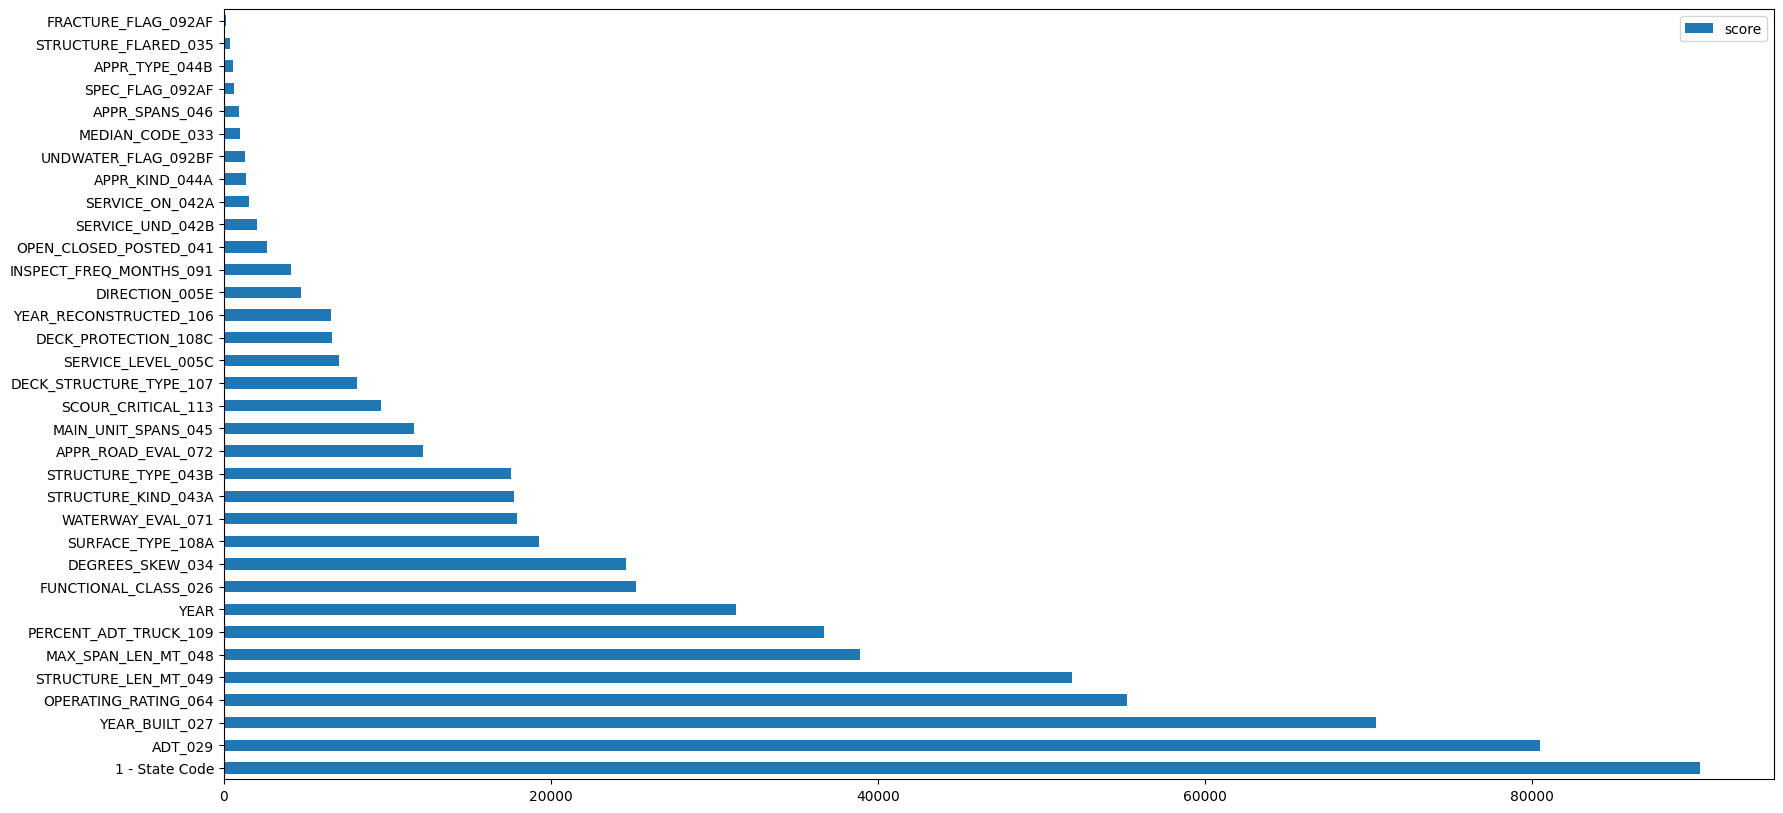

In [61]:
feature_import = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_import.keys())
values = list(feature_import.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

## Models w/Climate Data, w/out Sufficiency Rating

#### Prep for modeling: drop cols, convert to category dtype, scale features, train-test split

In [72]:
featureNames_c = (concreteSteel.drop(columns= ['avg_COND'])).columns.tolist()

In [62]:
# drop unneeded cols
drop_cols = ['Year', 'REL_BRIDGE_AGE', 'DECK_GEOMETRY_EVAL_068', 'MEMBRANE_TYPE_108B', 'SUFFICIENCY_RATING', '8 - Structure Number', 'STRUCTURE_NUMBER_008_ID']
concreteSteel = concreteSteel.drop(columns= drop_cols)

In [ ]:
concreteSteel.info()

In [64]:
# convert specific cols to cat dtype
cat_cols = ['1 - State Code', 'SERVICE_LEVEL_005C', 'DIRECTION_005E', 'MEDIAN_CODE_033', 'SERVICE_ON_042A', 'SERVICE_UND_042B',
           'STRUCTURE_KIND_043A', 'STRUCTURE_TYPE_043B', 'APPR_KIND_044A', 'APPR_TYPE_044B', 'DECK_STRUCTURE_TYPE_107',
           'SURFACE_TYPE_108A', 'DECK_PROTECTION_108C']
concreteSteel[cat_cols] = concreteSteel[cat_cols].astype('category')

In [65]:
# scale numerical features
numerical = concreteSteel.select_dtypes(include= 'float64').columns
concreteSteel.loc[:, numerical] = StandardScaler().fit_transform(concreteSteel.loc[:, numerical])

In [66]:
# set up train and test data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(concreteSteel.drop(columns= ['avg_COND']),
                                                    concreteSteel['avg_COND'],
                                                    test_size= 0.2,
                                                    random_state= 42)

In [67]:
lr_c = LinearRegression()
lr_c.fit(X_train_c, y_train_c)

LinearRegression()

In [68]:
lr_c_score = lr_c.score(X_test_c, y_test_c)
lr_c_score

0.9162055164977527

In [69]:
lr_c_adj_r2 = get_adj_r2(lr_c_score)
lr_c_adj_r2

0.9161163384780058

In [85]:
lr_c_coef = lr_c.coef_.tolist()
for i in range(len(featureNames_c)):
    print(lr_c_coef[i], featureNames_c[i])

-0.0007036112663513748 1 - State Code
0.023607708034791057 Average Relative Humidity
-0.05222899995347907 Average Temperature
0.013235141315127194 Maximum Temperature
0.011439718851420366 Mean Wind Speed
-0.014981096633116142 Minimum Temperature
0.015811650912812697 Number of Freeze-Thaw Cycles
0.00930972979538601 Number of Snowfall Days
-0.015954778493257958 Number of Days with Measurable Precipitation
-0.07805120081284003 Number of Days with Temperature Below 0?C
0.007604998421442133 Prevailing Wind Direction
-0.01697729397569489 Time of Wetness
-0.00014661267283050394 Total Precipitation
0.0002722736804459114 SERVICE_LEVEL_005C
0.0021242806948250648 DIRECTION_005E
0.003656640051279525 FUNCTIONAL_CLASS_026
0.03942979573651445 YEAR_BUILT_027
-543063687296.7094 TRAFFIC_LANES_ON_028A
-202883455631.97485 TRAFFIC_LANES_UND_028B
0.017100641268061212 ADT_029
0.033917022187261336 MEDIAN_CODE_033
0.0022403821026294457 DEGREES_SKEW_034
0.0019820443963481926 STRUCTURE_FLARED_035
-0.008072921266

In [76]:
dt_c = DecisionTreeRegressor(random_state= 42)

In [77]:
cv_dt_c = cross_val_score(estimator= dt_c, X= X_train_c, y= y_train_c, scoring= 'r2')
cv_dt_c

array([0.99395714, 0.99200302, 0.99493504, 0.99563383, 0.99122382])

In [78]:
np.mean(cv_dt_c)

0.9935505707329227

In [79]:
values_c = get_adj_r2(cv_dt_c)
dt_c_adj_r2 = values_c.mean()
dt_c_adj_r2

0.9935437069477843

In [80]:
enet_c = ElasticNet(random_state= 0)
enet_c.fit(X_train_c, y_train_c)

ElasticNet(random_state=0)

In [82]:
enet_c_score = enet_c.score(X_test_c, y_test_c)
enet_c_score

0.052395122047018794

In [83]:
enet_c_adj_r2 = get_adj_r2(enet_c_score)
enet_c_adj_r2

0.051386636488227166

In [84]:
enet_c_coef = enet_c.coef_.tolist()
for i in range(len(featureNames_c)):
    print(enet_c_coef[i], featureNames_c[i])

-0.00037414803531742654 1 - State Code
-0.0 Average Relative Humidity
-0.0 Average Temperature
0.0 Maximum Temperature
0.0 Mean Wind Speed
-0.0 Minimum Temperature
0.0 Number of Freeze-Thaw Cycles
0.0 Number of Snowfall Days
-0.0 Number of Days with Measurable Precipitation
0.0 Number of Days with Temperature Below 0?C
0.0 Prevailing Wind Direction
-0.0 Time of Wetness
-0.0 Total Precipitation
0.0 SERVICE_LEVEL_005C
0.0 DIRECTION_005E
-0.0 FUNCTIONAL_CLASS_026
0.047506670712218944 YEAR_BUILT_027
0.0 TRAFFIC_LANES_ON_028A
0.0 TRAFFIC_LANES_UND_028B
0.0 ADT_029
0.0 MEDIAN_CODE_033
-0.0 DEGREES_SKEW_034
0.0 STRUCTURE_FLARED_035
-0.0 OPEN_CLOSED_POSTED_041
-0.0 SERVICE_ON_042A
0.0 SERVICE_UND_042B
0.0 STRUCTURE_KIND_043A
0.0 STRUCTURE_TYPE_043B
0.0 APPR_KIND_044A
-0.0 APPR_TYPE_044B
0.0 MAIN_UNIT_SPANS_045
-0.0 APPR_SPANS_046
0.0 MAX_SPAN_LEN_MT_048
0.0 STRUCTURE_LEN_MT_049
0.0 DECK_COND_058
0.0 SUPERSTRUCTURE_COND_059
0.0 SUBSTRUCTURE_COND_060
0.0 CHANNEL_COND_061
0.0 CULVERT_COND_062
0.0

In [86]:
rr_c = Ridge(random_state= 42)
rr_c.fit(X_train_c, y_train_c)

Ridge(random_state=42)

In [87]:
rr_c_score = rr_c.score(X_test_c, y_test_c)
rr_c_score

0.9162120617121162

In [88]:
rr_c_adj_r2 = get_adj_r2(rr_c_score)
rr_c_adj_r2

0.9161228906580934

In [90]:
xgb_c = XGBRegressor(n_estimators= 1000, max_depth= 10, random_state= 42, enable_categorical= True)
xgb_c.fit(X_train_c, y_train_c)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [92]:
xgb_c_score = xgb_c.score(X_test_c, y_test_c)
xgb_c_score

0.9963035997912838

In [93]:
xgb_c_adj_r2 = get_adj_r2(xgb_c_score)
xgb_c_adj_r2

0.996299665908801

<Axes: >

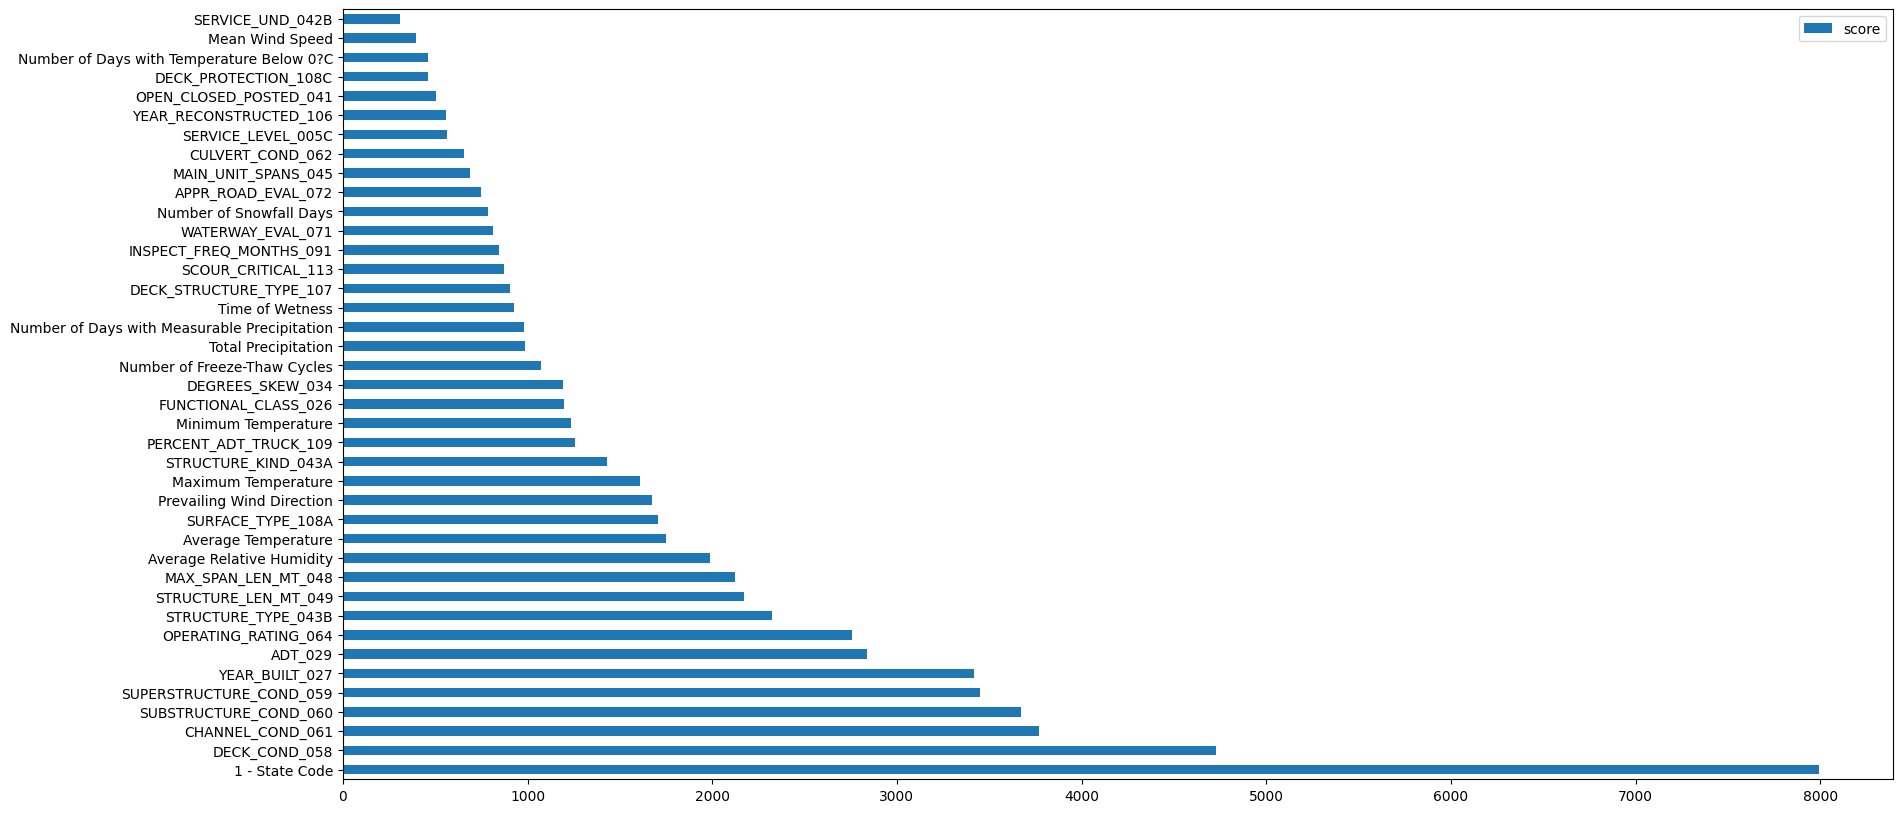

In [94]:
feature_import_c = xgb_c.get_booster().get_score(importance_type='weight')
keys_c = list(feature_import_c.keys())
values_c = list(feature_import_c.values())

data_c = pd.DataFrame(data=values_c, index=keys_c, columns=["score"]).sort_values(by = "score", ascending=False)
data_c.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
### look at doing random forest/xgboost as well
### look at grid search for best model(s)
### feature importance for best model(s)

### maybe try removing even more features?

<Axes: >

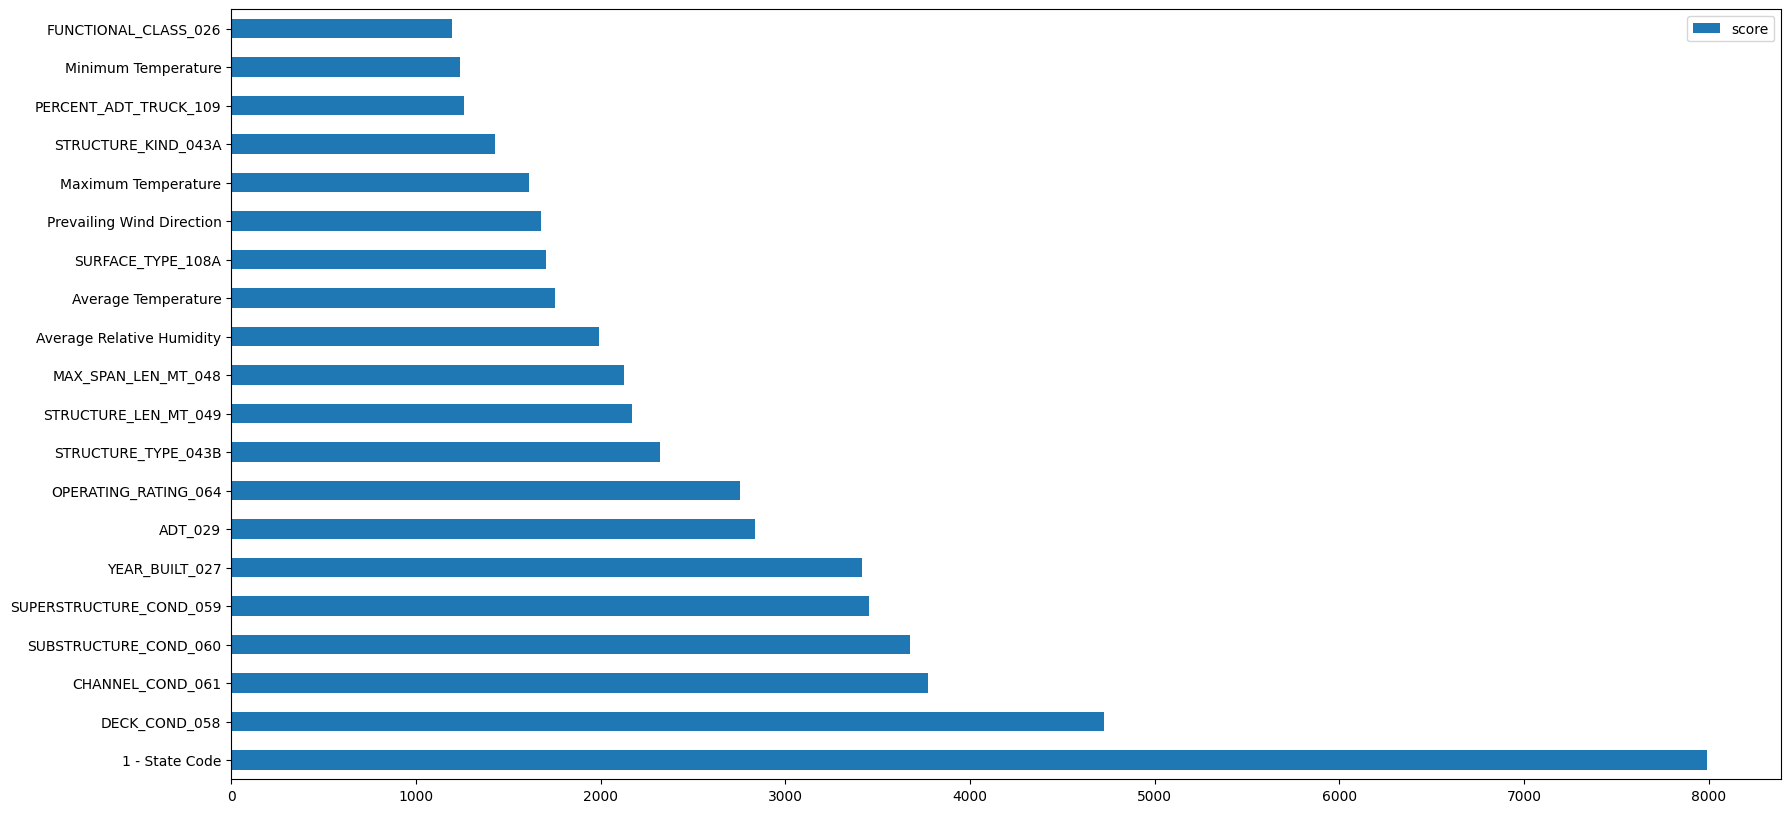

In [99]:
feature_import_c = xgb_c.get_booster().get_score(importance_type='weight')
keys_c = list(feature_import_c.keys())
values_c = list(feature_import_c.values())

data_c = pd.DataFrame(data=values_c, index=keys_c, columns=["score"]).sort_values(by = "score", ascending=False)
data_c.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [101]:
concreteSteel.count()

1 - State Code                                  178722
Average Relative Humidity                       178722
Average Temperature                             178722
Maximum Temperature                             178722
Mean Wind Speed                                 178722
Minimum Temperature                             178722
Number of Freeze-Thaw Cycles                    178722
Number of Snowfall Days                         178722
Number of Days with Measurable Precipitation    178722
Number of Days with Temperature Below 0?C       178722
Prevailing Wind Direction                       178722
Time of Wetness                                 178722
Total Precipitation                             178722
SERVICE_LEVEL_005C                              178722
DIRECTION_005E                                  178722
FUNCTIONAL_CLASS_026                            178722
YEAR_BUILT_027                                  178722
TRAFFIC_LANES_ON_028A                           178722
TRAFFIC_LA